# Time-Series with `pandas`

*Space-Time Analytics — Lecture 2d*

* **Prof. Carson J. Q. Farmer**  
    <i class="fa-fw fa fa-twitter"></i> [@carsonfarmer](https://twitter.com/carsonfarmer)  
    <i class="fa-fw fa fa-globe"></i> [carsonfarmer.com](https://carsonfarmer.com)  
    <i class="fa-fw fa fa-envelope-o"></i> [carson.farmer@colorado.edu](mailto:carson.farmer@colorado.edu)  
    <i class="fa-fw fa fa-github-alt"></i> [github.com/carsonfarmer](https://github.com/carsonfarmer)  
    <i class="fa-fw fa fa-briefcase"></i> Guggenheim Building Room 207  
    <i class="fa-fw fa fa-clock-o"></i> Wednesdays 2:00-3:00 PM and 4:15-5:15 PM  

## Introduction

In the previous exercise we looked at very basic ways of working with `pandas`. Here we are going to introduce some more 'advanced' (but still basic time-series 'tricks'), including how to:

* Create time-series' from existing data-sources
* Create seasonal means with `resample`
* Create multi-year monthly means with `groupby`
* Compute rolling statistics

## Module Import/Setup

First we have to import necessary modules:

In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame, Panel
import matplotlib.pyplot as plt
pd.set_option('max_columns', 50) # Limit maximum numbers of rows

And "switch on" inline graphics for the notebook:

In [2]:
% matplotlib inline

## Getting Data: Pressure Oscillations

For our examples, we are going to start with [Arctic Oscillation (AO)](http://en.wikipedia.org/wiki/Arctic_oscillation) and [North Atlantic Oscillation (NAO)](http://en.wikipedia.org/wiki/North_Atlantic_oscillation) time-series data\*:

<i class="fa fa-database"></i> [monthly.ao.index.b50.current.ascii](http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii)  
<i class="fa fa-database"></i> [norm.nao.monthly.b5001.current.ascii](http://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii)

<br/>
<div class="alert alert-info" style="font-size: .8em;">
\* Moving forward, the <i class="fa fa-database"></i> icon is the convention I'll use for alerting you to input datasets.
</div>

You can also download the data yourself [from here](http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii), and then load via `pandas` from file.. If you're on \*nix machine, you can do it directly from a `jupyter` notebook using a system call to `wget`:

In [3]:
!wget -P files http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii

--2016-08-28 18:44:34--  http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/monthly.ao.index.b50.current.ascii
Resolving www.cpc.ncep.noaa.gov... 140.90.101.63
Connecting to www.cpc.ncep.noaa.gov|140.90.101.63|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19975 (20K) [text/plain]
Saving to: 'files/monthly.ao.index.b50.current.ascii.2'

monthly.ao.index.b5 100%[=====================>]  19.51K  --.-KB/s   in 0.07s  

2016-08-28 18:44:35 (285 KB/s) - 'files/monthly.ao.index.b50.current.ascii.2' saved [19975/19975]



Here's what the top of that text file looks like:

In [4]:
!head files/monthly.ao.index.b50.current.ascii

 1950    1  -0.60310E-01
 1950    2   0.62681E+00
 1950    3  -0.81275E-02
 1950    4   0.55510E+00
 1950    5   0.71577E-01
 1950    6   0.53857E+00
 1950    7  -0.80248E+00
 1950    8  -0.85101E+00
 1950    9   0.35797E+00
 1950   10  -0.37890E+00


Every line in the file consist of three elements: year, month, value.

## Loading Data

We can load this data into `Python` using `pandas` via the `read_table` function:

In [5]:
ao = pd.read_table('files/monthly.ao.index.b50.current.ascii', sep='\s*', engine="python",
                   parse_dates={'dates':[0, 1]}, header=None, index_col=0, squeeze=True)

/Users/carsonfarmer/miniconda3/envs/space-time/lib/python3.5/site-packages/pandas/io/parsers.py:1728: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/carsonfarmer/miniconda3/envs/space-time/lib/python3.5/site-packages/pandas/io/parsers.py:1730: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


Alternatively, we can actually load this data directly from the orignal url:

In [6]:
base = "http://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/"
current = "monthly.ao.index.b50.current.ascii"
url = base + current
ao = pd.read_table(url, sep='\s*', engine="python",
                   parse_dates={'dates':[0, 1]}, header=None,
                   index_col=0, squeeze=True)

/Users/carsonfarmer/miniconda3/envs/space-time/lib/python3.5/site-packages/pandas/io/parsers.py:1728: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/carsonfarmer/miniconda3/envs/space-time/lib/python3.5/site-packages/pandas/io/parsers.py:1730: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


Some explanations:

* First argument is obviously the file name
* `'\s*'`
    * Regular expression that describes the separator
* `parse_dates`
    * Combine columns 0 and 1, convert resulting column to dates and give it the name `"dates"`
* `header`
    * Don't use 0 row as header
* `index_col`
    * Make column 0 the index
    * This will be already result of the `parse_dates` parsing
* `squeeze`:
    * Create `Series` instead of `DataFrame`

And here is the top of our `Series`:

In [7]:
print(ao.head())
print(ao.shape)  # The shape of the Data Frame

dates
1950-01-01   -0.060310
1950-02-01    0.626810
1950-03-01   -0.008128
1950-04-01    0.555100
1950-05-01    0.071577
Name: 2, dtype: float64
(799,)


## Time Series

Right now, we have a time-`Series` object with a `DatetimeIndex`. Now this data can be manipulated naturally and easily. However, you may notice the 'day' of each entry is the 1st of the month. This should really be the last of the month... we can fix this by:

* Manually creating a range of dates for our time series:
    * From the file it is clear that the records start in January 1950 and end in July 2016
    * Frequency of the data is one month (freq='M')

In [8]:
dates = pd.date_range('1950-01', '2016-08', freq='M')

The syntax is quite simple, and this is one of the reasons why `pandas` is awesome for time data. Another thing to mention is that we put *August* 2016 instead of *July*. This is because the interval is *open* on the right side. You can check if the range of dates is properly generated:

In [9]:
print(dates.shape)

(799,)


Now we are ready to update the index of our time-series:

In [10]:
ao.index = dates

<br/>
<div class="alert alert-info" style="font-size: .8em;">
Manipulating dates and `datetime` objects is super tricky for the uninitiated, so feel free to have a look at [this 'YouTube' video](https://youtu.be/JNfxr4BQrLk) which covers much of the basics of `datetimes` in `Python`.
</div>

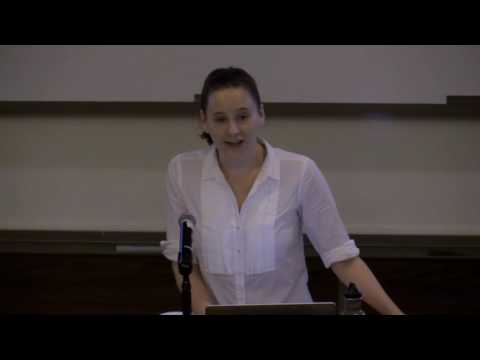

In [1]:
from IPython.display import display, YouTubeVideo
# Skim over this to get familiar with 'time' in Python
display(YouTubeVideo("JNfxr4BQrLk", start=306))
# Here's an older video from Pandas creator Wes McKinney:
# https://youtu.be/0unf-C-pBYE

Now we can plot complete time series:

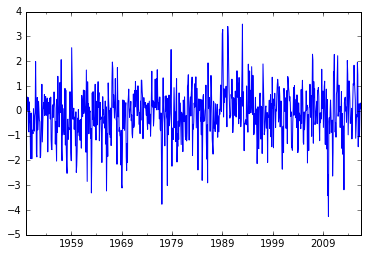

In [12]:
ax = ao.plot()

or just part of it (zoom in on 80s and 90s):

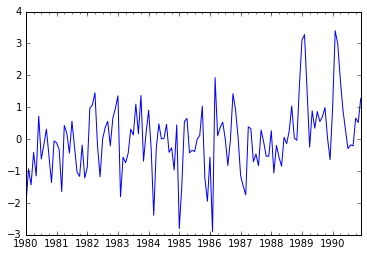

In [13]:
ax = ao['1980':'1990'].plot()

or an even smaller part:

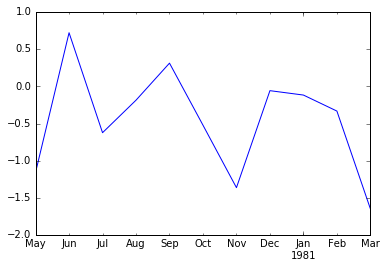

In [14]:
ax = ao['1980-05':'1981-03'].plot()

Reference to the time periods is done in a very natural way. You, of course, can also get individual values by index (date in our case):

In [15]:
ao['1960-01']

1960-01-31   -2.4842
Freq: M, Name: 2, dtype: float64

And what if we choose only one year?

In [16]:
ao['1960']  # How cool is that?!

1960-01-31   -2.484200
1960-02-29   -2.212400
1960-03-31   -1.624600
1960-04-30   -0.297310
1960-05-31   -0.857430
1960-06-30    0.054978
1960-07-31   -0.619060
1960-08-31   -1.007900
1960-09-30   -0.381640
1960-10-31   -1.187000
1960-11-30   -0.553230
1960-12-31   -0.342950
Freq: M, Name: 2, dtype: float64

How about selecting ranges?

In [17]:
ao[ao > 2]

1957-01-31    2.0621
1959-02-28    2.5445
1978-11-30    2.4695
1989-01-31    3.1060
1989-02-28    3.2793
1990-02-28    3.4016
1990-03-31    2.9900
1993-01-31    3.4953
2006-12-31    2.2817
2007-01-31    2.0338
2011-04-30    2.2748
2011-12-31    2.2208
2013-11-30    2.0290
Name: 2, dtype: float64

## Data Frame

Now let's make things a bit more interesting and download more data. This time we'll grab the NOA time series:

In [18]:
# You *could*s download it first
# !wget http://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/norm.nao.monthly.b5001.current.ascii
# Or just get it directly:
base = "http://www.cpc.ncep.noaa.gov/products/precip/CWlink/pna/"
current = "norm.nao.monthly.b5001.current.ascii"
url = base + current
nao = pd.read_table(url, sep='\s*', engine="python",
                   parse_dates={'dates':[0, 1]}, header=None,
                   index_col=0, squeeze=True)

/Users/carsonfarmer/miniconda3/envs/space-time/lib/python3.5/site-packages/pandas/io/parsers.py:1728: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())
/Users/carsonfarmer/miniconda3/envs/space-time/lib/python3.5/site-packages/pandas/io/parsers.py:1730: FutureWarning: split() requires a non-empty pattern match.
  yield pat.split(line.strip())


In [19]:
# Update index to reflect end-of-month dates
nao.index = pd.date_range('1950-01', '2016-08', freq='M')

Now we create a `DataFrame` that will contain both AO and NAO data, with appropriate headers:

In [20]:
aonao = DataFrame({'AO' : ao, 'NAO' : nao})  # Both indexes have to be the same!

One can plot the data straight away:

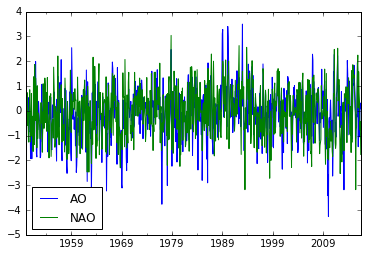

In [21]:
ax = aonao.plot()

Or have a look at the first several rows:

In [22]:
aonao.head()

,AO,NAO
1950-01-31,-0.060310,0.92
1950-02-28,0.626810,0.40
1950-03-31,-0.008128,-0.36
1950-04-30,0.555100,0.73
1950-05-31,0.071577,-0.59


We can reference each column by its name:

In [23]:
aonao['NAO'].head()

1950-01-31    0.92
1950-02-28    0.40
1950-03-31   -0.36
1950-04-30    0.73
1950-05-31   -0.59
Freq: M, Name: NAO, dtype: float64

or as property of the `DataFrame` object (if the name of the variable is a valid `Python` name):

In [24]:
aonao.NAO.head()

1950-01-31    0.92
1950-02-28    0.40
1950-03-31   -0.36
1950-04-30    0.73
1950-05-31   -0.59
Freq: M, Name: NAO, dtype: float64

We can simply add column to the `DataFrame`:

In [25]:
aonao['Diff'] = aonao['AO'] - aonao['NAO']
aonao.head()

,AO,NAO,Diff
1950-01-31,-0.060310,0.92,-0.980310
1950-02-28,0.626810,0.40,0.226810
1950-03-31,-0.008128,-0.36,0.351872
1950-04-30,0.555100,0.73,-0.174900
1950-05-31,0.071577,-0.59,0.661577


And delete it:

In [26]:
del aonao['Diff']
aonao.tail()

,AO,NAO
2016-03-31,0.280240,0.73440
2016-04-30,-1.051100,0.37514
2016-05-31,-0.035739,-0.77358
2016-06-30,0.312880,-0.43251
2016-07-31,0.084758,-1.76030


Date slicing will also work:

In [27]:
aonao['1981-01':'1981-03']

,AO,NAO
1981-01-31,-0.11634,0.37
1981-02-28,-0.33158,0.92
1981-03-31,-1.64470,-1.19


even in some crazy combinations:

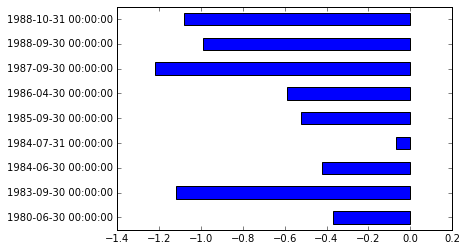

In [28]:
import datetime
aonao.ix[(aonao.AO > 0) & (aonao.NAO < 0) 
        & (aonao.index > datetime.datetime(1980, 1, 1)) 
        & (aonao.index < datetime.datetime(1989, 1, 1)),
        'NAO'].plot(kind='barh')

Here we used the special [advanced indexing attribute `.ix`](http://pandas.pydata.org/pandas-docs/stable/indexing.html#advanced-indexing-with-labels). We choose all NAO values in the 1980s for months where AO is positive and NAO is negative, and then plot them!

## Statistics

Back to simple stuff. We can obtain statistical information over elements of the `DataFrame`. Default is column wise:

In [29]:
aonao.mean()

AO    -0.118080
NAO   -0.018449
dtype: float64

In [30]:
aonao.max()

AO     3.4953
NAO    3.0400
dtype: float64

In [31]:
aonao.min()

AO    -4.2657
NAO   -3.1800
dtype: float64

You can also do it row-wise:

In [32]:
aonao.mean(1).head()

1950-01-31    0.429845
1950-02-28    0.513405
1950-03-31   -0.184064
1950-04-30    0.642550
1950-05-31   -0.259211
Freq: M, dtype: float64

Or get everything at once:

In [33]:
aonao.describe()

,AO,NAO
count,799.000000,799.000000
mean,-0.118080,-0.018449
std,1.005797,1.012627
min,-4.265700,-3.180000
25%,-0.664700,-0.760180
50%,-0.045949,0.010000
75%,0.472720,0.688500
max,3.495300,3.040000


## Resampling

* `pandas` provides an easy way to 'resample' data to different time frequencies
* The main parameter needed for resampling is the time **period**
    * You can then specify what to do with the resampled data, such as compute a mean, min, etc.
* The following example calculates annual ('A') mean and plots it:

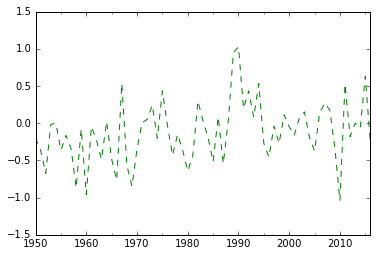

In [34]:
ax = ao.resample("A").mean().plot(style='g--')

The median is similarly computed (and plotted):

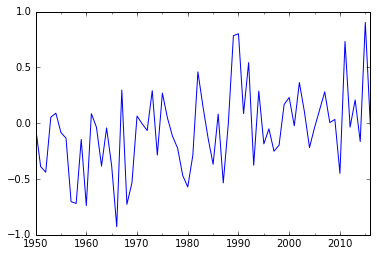

In [35]:
ax = ao.resample("A").median().plot()

You can use pretty much any function for resampling, for example we can use `np.max` (and for fun, we change the frequency to 3 years):

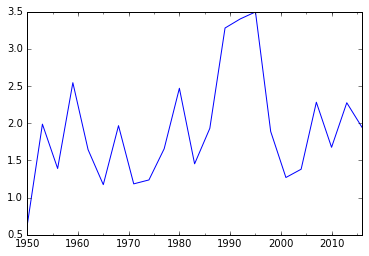

In [36]:
ax = ao.resample("3A").apply(np.max).plot()

You can specify several functions at once as a list:

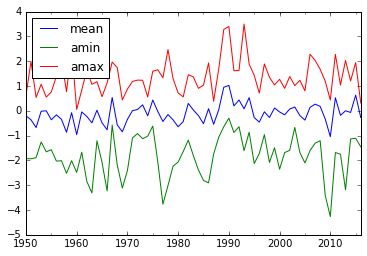

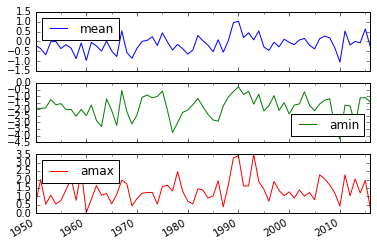

In [37]:
AO_mm = ao.resample("A").apply(['mean', np.min, np.max])

ax = AO_mm['1900':'2020'].plot()  # Without subplots
ax = AO_mm['1900':'2020'].plot(subplots=True)

### Seasonal means

If you don't mind sacrificing your first two data points (because they don't represent a whole season), there is a way to do a similar thing by resampling to `'3M'` (3 month) intervals starting from March (third data point):

In [38]:
m3_mean = aonao["1950-03-31":].resample('3M', closed='left').mean()
m3_mean.head()

,AO,NAO
1950-06-30,0.206183,-0.073333
1950-09-30,-0.371640,-0.456667
1950-12-31,-0.178680,-0.053333
1951-03-31,-0.804333,-0.080000
1951-06-30,-1.191120,-0.610000


If we want to plot only winter months, we would then select all 'Marchs' (month 3):

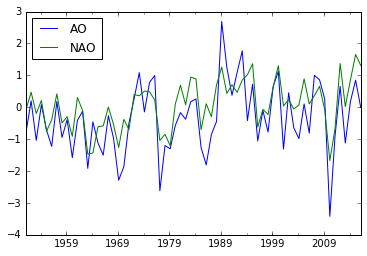

In [39]:
ax = m3_mean[m3_mean.index.month==3].plot()

In [40]:
# Another way to do 'seasonal' means is to use quarters...
aonao.resample('Q-NOV').mean().head()  # November shifted quarters

,AO,NAO
1950-02-28,0.283250,0.660000
1950-05-31,0.206183,-0.073333
1950-08-31,-0.371640,-0.456667
1950-11-30,-0.178680,-0.053333
1951-02-28,-0.804333,-0.080000


### Multi-year monthly means

First step will be to add another column to our DataFrame with month numbers:

In [41]:
aonao['month'] = aonao.index.month
aonao.head()

,AO,NAO,month
1950-01-31,-0.060310,0.92,1
1950-02-28,0.626810,0.40,2
1950-03-31,-0.008128,-0.36,3
1950-04-30,0.555100,0.73,4
1950-05-31,0.071577,-0.59,5


Now we can use [`groupby`](http://pandas.pydata.org/pandas-docs/stable/groupby.html) to group our values by months and calculate mean for each of the groups (month in our case):

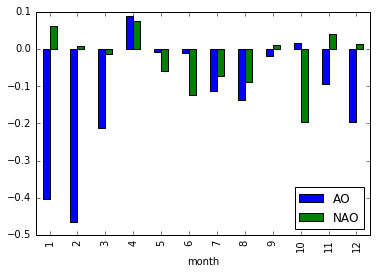

In [42]:
monmean = aonao['1950':'2013'].groupby('month').mean()
ax = monmean.plot(kind='bar')

There are very large negative values for winter months of AO. In order to see what is going on there it is useful to look at the [box plots](http://en.wikipedia.org/wiki/Box_plot) for every month:

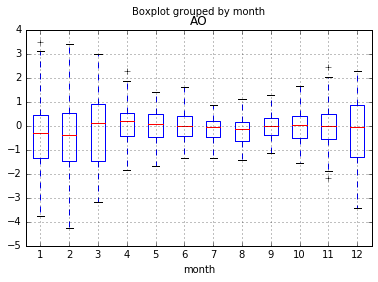

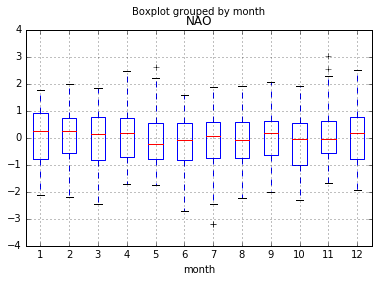

In [43]:
ax = aonao.boxplot(column=['AO'], by='month')
ax = aonao.boxplot(column=['NAO'], by='month')

While NAO show more or less uniform spread, AO have pronounced seasonal variations, with the largest spread during winter months.

## Moving (rolling) statistics

`pandas` provides a great collection of moving statistics, including a rolling mean:

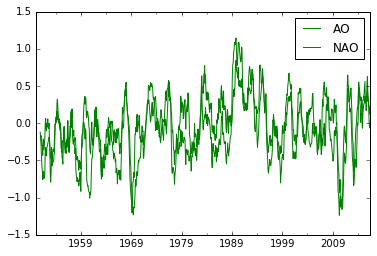

In [44]:
ax = aonao[["AO", "NAO"]].rolling(center=False, window=12).mean().plot(style='-g')

Rolling correlation:

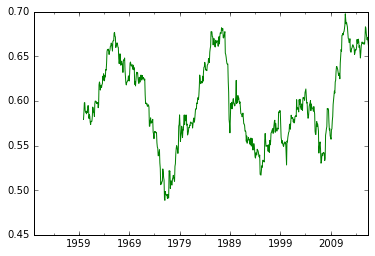

In [45]:
ax = aonao.AO.rolling(window=120).corr(other=aonao.NAO).plot(style='-g')

By the way, getting correlation coefficients for members of the `DataFrame` is as simple as:

In [46]:
aonao[["AO", "NAO"]].corr()

,AO,NAO
AO,1.000000,0.609763
NAO,0.609763,1.000000
